---
title: Auditing Bias
author: Evan Flaks
date: '2025-03-09'
image: "bias.jpeg"
description: "Building a model that predicts employment status and auditing the model's racial bias"
format: html
---

# Abstract

This project investigates the use of machine learning to predict employment status based on demographic and socioeconomic variables from the U.S. Census PUMS data. Using the folktables library, we sourced data from the state of Maryland and preprocessed it to extract relevant features. A Random Forest model was trained to classify employment status, and its performance was evaluated on the general Maryland population. Then, a bias audit was conducted to assess potential disparities in model predictions across different racial and demographic groups. The results highlight both the predictive capabilities of the model and the ethical concerns related to bias in employment predictions.

# Downloading Data

First we will download some PUMS data from the state of Maryland using folktables. 

In [320]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "MD"

data_source = ACSDataSource(survey_year='2023', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,STATE,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2023GQ0000068,5,1,201,3,24,1019518,27,62,...,27,29,24,25,29,27,25,29,28,28
1,P,2023GQ0000079,5,1,502,3,24,1019518,13,21,...,13,26,17,15,13,32,0,2,2,13
2,P,2023GQ0000088,5,1,1400,3,24,1019518,25,35,...,32,25,70,54,42,24,2,34,49,23
3,P,2023GQ0000093,5,1,1300,3,24,1019518,19,61,...,14,19,23,27,2,22,27,3,20,2
4,P,2023GQ0000100,5,1,802,3,24,1019518,106,73,...,136,206,9,15,106,209,115,210,211,15


# Data Cleaning

The dataset has a *lot* of features. For our modeling task, we will only use the following possible features

In [321]:
possible_features=['AGEP', 'SCHL', 'MAR', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()


,AGEP,SCHL,MAR,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,62,17.0,5,1,NaN,1,1.0,4.0,4,1,2,1,1.0,1,1,6.0
1,21,19.0,5,2,NaN,1,1.0,4.0,2,1,2,2,2.0,2,9,6.0
2,35,16.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,2,6.0
3,61,18.0,3,1,NaN,1,3.0,4.0,4,1,2,2,1.0,1,1,6.0
4,73,13.0,5,1,NaN,1,1.0,4.0,4,1,2,2,2.0,1,1,6.0


For documentation on what these features mean, please consult the appendix of [this paper](https://arxiv.org/pdf/2108.04884) that introduced the package.

I am going to train my model on all of the possible features aside from race, because we will be auditing for racial bias later. I will use these features to predict employment status (ESR), so that column of data will also be discluded from my training.

In [322]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

Now we can construct a BasicProblem that expresses our wish to use these feautures to predict employment status (ESR), using race (RAC1P) as the group label.

In [323]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

Before we touch the data anymore, we should perform a train-test split, training our model on 80% of the data, and testing on the remaining 20%.

In [324]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Data Exploration

Now we want to answer some basic questions about the data we are working with. We can answer these questions by turning our training data into a data frame for easy analysis.

In [341]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train
df.head()

,AGEP,SCHL,MAR,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,4.0,1.0,5.0,2.0,5.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1,False
1,2.0,0.0,5.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1,False
2,49.0,21.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1,False
3,47.0,15.0,5.0,1.0,0.0,3.0,1.0,4.0,1.0,1.0,2.0,2.0,1.0,2.0,1,True
4,0.0,0.0,5.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1,False


### 1. How many individuals are in the data?

In [342]:
df.shape[0]

49624

### 2. Of these individuals, what proportion are employed?

In [343]:
df["label"].mean()

0.4898839271320329

### 3. Of these individuals, how many are in each racial group?

In [363]:
# Count the number of employed people in each racial group
df[df["label"] == 1].groupby("group")["label"].count()

group
1    14026
2     5131
3       93
4        1
5       19
6     2046
7       12
8     1247
9     1735
Name: label, dtype: int64

The race groups are broken down as follows:<br>
– 1: White alone <br>
– 2: Black or African American alone <br>
– 3: American Indian alone<br>
– 4: Alaska Native alone<br>
– 5: American Indian and Alaska Native<br>
– 6: Asian alone<br>
– 7: Native Hawaiian and Other Pacific Islander alone<br>
– 8: Some Other Race alone<br>
– 9: Two or More Races<br>

### 4. In each group, what proportion of individuals have target label equal to 1, i.e. what proportion of people in each race is employed?

In [348]:
# Compute the proportion of employed individuals in each racial group
df.groupby("group")["label"].mean()


group
1    0.491761
2    0.478415
3    0.547059
4    0.333333
5    0.372549
6    0.544874
7    0.666667
8    0.513169
9    0.439241
Name: label, dtype: float64

### Now I will look for some intersectional trends.

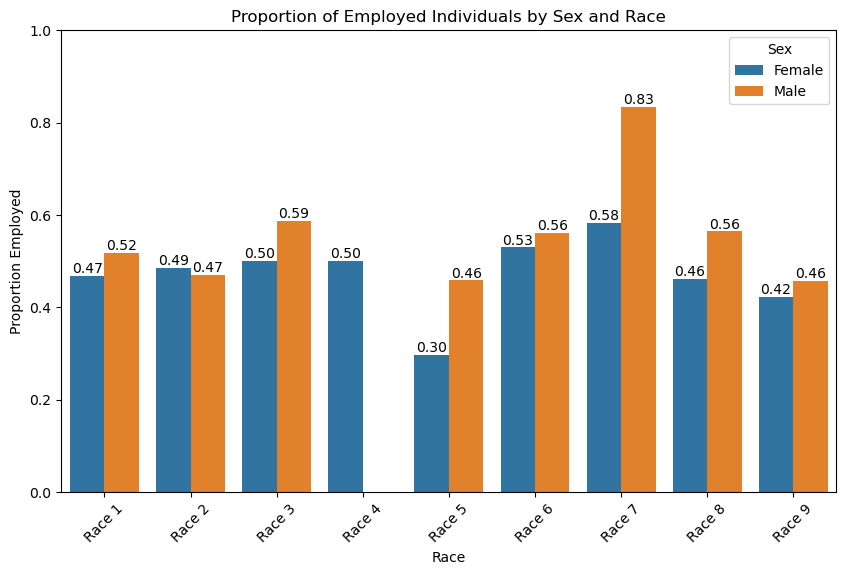

In [366]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame with the training features
df = pd.DataFrame(X_train, columns=features_to_use)

# Add the race and employment status columns separately
df["Race"] = group_train  # This is the group label provided separately
df["Employment Status"] = y_train  # 1 = Employed, 0 = Not employed

# Extract Sex feature
df["Sex"] = X_train[:, features_to_use.index("SEX")]
# Replace numeric values with "Male" and "Female"
df["Sex"] = df["Sex"].replace({1: "Male", 2: "Female"})

# Rename race labels dynamically
unique_races = df["Race"].unique()
race_labels = {race: f"Race {race}" for race in unique_races}
df["Race"] = df["Race"].replace(race_labels)

# Compute the proportion of employed individuals by race and sex
intersectional_proportions = df.groupby(["Race", "Sex"])["Employment Status"].mean().reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=intersectional_proportions, x="Race", y="Employment Status", hue="Sex")

# Add numerical labels on top of each bar
for p in ax.patches:
    if p.get_height() > 0:  # Only annotate bars with nonzero height
        ax.annotate(f'{p.get_height():.2f}',  # Format proportion to 2 decimal places
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

# Adjust plot aesthetics
plt.title("Proportion of Employed Individuals by Sex and Race")
plt.ylabel("Proportion Employed")
plt.xlabel("Race")
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.legend(title="Sex")
plt.ylim(0, 1)

# Display the plot
plt.show()

This visualization gives us some valuable insights. The main outliers are only 30% of female Alaskan Natives (race 5) are employed and around 83% of male Pacific Islanders (race 7) are employed. Another thing to note is there are 0 employed male Alaskan natives (race 4), and this is because the training data set only includes one employed Alaskan native, and that person is female. Aside from those outliers, members from all racial groups have similar proportion of employed individuals (0.42-0.59), with males being employed at higher rates than women for every racial group besides Black people (race 2).

# Training a Model



This Random Forest model undergoes hyperparameter tuning using GridSearchCV, where different values for max_depth (the maximum depth of each tree) are tested through 5-fold cross-validation to determine the best-performing configuration based on accuracy. Once the optimal max_depth is found, the best model is evaluated using cross-validation to estimate its generalization performance. Finally, the model is retrained on the full training dataset to maximize learning before deployment.

In [349]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Define hyperparameters to tune
param_grid_rf = {'max_depth': [3, 5, 10, None]}  # Tune max depth

# Perform Grid Search with Cross-Validation
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

# Get the best model from Grid Search
best_rf_model = grid_rf.best_estimator_

# Print the best max_depth value
print("Best max_depth for Random Forest:", grid_rf.best_params_['max_depth'])

# Evaluate the model with cross-validation
rf_score = cross_val_score(best_rf_model, X_train, y_train, cv=5).mean()
print(f"Cross-validation accuracy: {rf_score:.4f}")

# Train the final model on the full training set
best_rf_model.fit(X_train, y_train)


Best max_depth for Random Forest: 10
Cross-validation accuracy: 0.8287


RandomForestClassifier(max_depth=10, random_state=0)

Based on our cross-validation results, the optimal accuracy of our model is achieved with a max_depth of 10.

With a max_depth of 10, our Random Forest model predicted employment with an accuracy of approximately 82% on the training data.

# Testing My Model


### Overall Accuracy and Precision

First let's see the overall accuracy of our model on the entire test set, without considering different racial groups.

In [419]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)
def compute_metrics(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)

    # Extract confusion matrix values manually
    tn = C[0, 0] 
    fp = C[0, 1] 
    fn = C[1, 0] 
    tp = C[1, 1] 

    # Compute metrics
    accuracy = (y_pred == y_true).mean()
    ppv = tp / (tp + fp) 
    fnr = fn / (fn + tp) 
    fpr = fp / (fp + tn)

    return pd.Series({"Accuracy": accuracy, "PPV": ppv, "FNR": fnr, "FPR": fpr})


In [420]:
compute_metrics(y_test, y_pred)

Accuracy    0.826388
PPV         0.792269
FNR         0.121975
FPR         0.223812
dtype: float64

### Testing By Racial Group

Now let's check out some of the metrics split up by racial group.

In [428]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create DataFrame with predictions and actual values
df_results = pd.DataFrame({"true_employment": y_test, "predicted_employment": y_pred, "race": group_test})

# Apply function to each subgroup
results_df = df_results.groupby("race").apply(lambda g: compute_metrics(g["true_employment"], g["predicted_employment"]))
results_df

,Accuracy,PPV,FNR,FPR
race,,,,
1,0.827839,0.801902,0.134550,0.208914
2,0.814081,0.770961,0.131336,0.235789
3,0.822222,0.777778,0.086957,0.272727
5,0.850000,0.700000,0.000000,0.230769
6,0.806999,0.768116,0.073786,0.336449
7,0.818182,0.750000,0.250000,0.142857
8,0.838879,0.808260,0.089701,0.240741
9,0.860887,0.803435,0.076754,0.192164


# Auditing For Racial Bias

Now let's analyze our data through the lens of various bias measures to see how it impacts different racial groups differently. To measure these biases, I will refer to the above results_df data frame that includes the model's metrics divied up by racial group.

### Calibration

Now I will preforming a check to see if my model is calibrated with respect to racial group. the code below calculates the actual true employment rate for each group, but only for cases where the model predicted employment. When I group by race and take the mean of Predicted Employment, it measures how often a positive prediction was actually correct within each racial group. This helps determine if the model’s positive predictions are equally reliable across racial groups.

In [429]:
import numpy as np

# Compute actual employment rate when model predicts 1, by racial group
calibration_check = df_results[df_results["predicted_employment"] == 1].groupby("race")["true_employment"].mean()
calibration_check

race
1    0.801902
2    0.770961
3    0.777778
5    0.700000
6    0.768116
7    0.750000
8    0.808260
9    0.803435
Name: true_employment, dtype: float64

While the model seems to be generally well calibrated, there is an outlier for racial group 5 (Alaska Native), which has 0.05 lower calibration than the next lowest group. This is most likely due to this group having much less data than the other groups, as there were only  19 employed Alaskan natives in the data set. Aside from this group, the model is generally well calibrated as actual employment rates for individuals predicted as employed is fairly consistent, ranging from 0.75 to 0.80. While it is not perfectly calibrated because the values have variance, the level of consistency and a small range indicates that there is no severe calibration bias. 

### Error Rate Balance 



Error rate balance requires that FPR and FNR be approximately equal across all groups. In my model, there is significant variation in both FNR and FPR across groups. FPR ranges from 0.143 to to 0.336 and FNR ranges between 0.000 and 0.25. This means that some groups are disproportionately classified as false positives or false negatives, and our model does not have balanced error-rates.  

### Statistical Parity

Now I will check for statistical parity, which is a fairness metric to determine whether different demographic groups receive favorable outcomes at the same rate. The code below checks the proportion of individuals predicted as employed (favorable outcome) within each group by grouping the dataset by Race and computing the mean of the predicted values. This tells us whether the model’s predictions are distributed equally across different groups.

In [402]:
# Compute the proportion of individuals predicted as employed (y_hat == 1) per group
statistical_parity_check = df_results.groupby("Race")["Predicted Employment"].mean()
statistical_parity_check

Race
1    0.533390
2    0.537954
3    0.600000
5    0.500000
6    0.658537
7    0.363636
8    0.593695
9    0.528226
Name: Predicted Employment, dtype: float64

A model satisfies statistical parity if each racial group receives the positive prediction at the same rate. Looking at our values from above, the predicted employment rates range from 0.363 (group 7) to 0.658 (group 6), with significant variation among all racial groups. Thus, my model does not achieve statistical parity. 

# Feasible FNR and FPR Rates

Alexandra Chouldechova's work on fair predictions provides us with the equation
$$
  FPR = \frac{1}{1-p}\frac{1-PPV}{PPV}(1-FNR)
$$

Now I will calculate feasible false positive rates for each group using the above equation by factoring in the prevelance (p). The code computes the prevalence for each group by averaging the true employment rates and then merges this dataframe with our previous results from above. Then, using the equation from above, it calculates a feasible FPR for each group.

In [431]:
import pandas as pd

# Assuming results_df already contains 'group', 'PPV', 'FNR', and 'FPR'
# Compute prevalence (p) for each group using y_test from df_results (individual-level data)
prevalence = df_results.groupby("race")["true_employment"].mean().reset_index()
prevalence.columns = ["race", "Prevalence"]

# Merge prevalence into results_df
results_df = results_df.merge(prevalence, on="race", how="left")

# Compute Feasible FPR using Equation (2.6)
results_df["Feasible_FPR"] = (results_df["Prevalence"] / (1 - results_df["Prevalence"])) * \
                             ((1 - results_df["PPV"]) / results_df["PPV"]) * \
                             (1 - results_df["FNR"])

results_df

,race,Accuracy,PPV,FNR,FPR,Prevalence,Feasible_FPR
0,1,0.827839,0.801902,0.134550,0.208914,0.494224,0.208914
1,2,0.814081,0.770961,0.131336,0.235789,0.477448,0.235789
2,3,0.822222,0.777778,0.086957,0.272727,0.511111,0.272727
3,5,0.850000,0.700000,0.000000,0.230769,0.350000,0.230769
4,6,0.806999,0.768116,0.073786,0.336449,0.546129,0.336449
5,7,0.818182,0.750000,0.250000,0.142857,0.363636,0.142857
6,8,0.838879,0.808260,0.089701,0.240741,0.527145,0.240741
7,9,0.860887,0.803435,0.076754,0.192164,0.459677,0.192164


Now I will recreate Chouldechova’s figure 5 from the reading by plotting the observed false negative rates (FNR) and false positive rates (FPR) for each group with the theoretically feasible FNR-FPR tradeoff lines derived from Equation 2.6. The tradeoff lines are calculated using the prevalence-adjusted feasible FPR values, showing the relationship between error rates across groups.

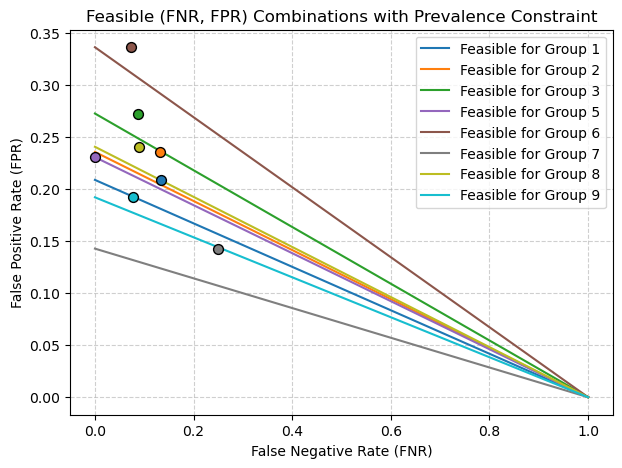

In [433]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract observed values from results_df
groups = results_df["race"]
FNR = results_df["FNR"]
FPR = results_df["FPR"]
Feasible_FPR = results_df["Feasible_FPR"]  # Precomputed from the equation

# Define colors for each group
colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))  # Using tab10 colormap

# Generate feasible FNR-FPR tradeoff line using equation
fnr_range = np.linspace(0, 1, 100)

# Compute target FPR (equalizing across all groups)
target_fpr = np.mean(FPR)

# Define prevalence (p) and positive predictive value (PPV) - Assumed fixed
p = 0.5  # Example prevalence
ppv = 0.6  # Example PPV

# Compute required FNR adjustments using Equation (2.6)
Required_FNR_Adjustment = 1 - (target_fpr * (1 - p) * ppv) / (p * (1 - ppv)) - FNR

# Store adjustments back into results_df
results_df["Required_FNR_Adjustment"] = Required_FNR_Adjustment

# Create figure
plt.figure(figsize=(7, 5))

# Plot feasible tradeoff lines and corresponding observed points
for i, group in enumerate(groups):
    color = colors[i]  # Assign color to group
    plt.plot(fnr_range, Feasible_FPR[i] * (1 - fnr_range), color=color, label=f"Feasible for Group {group}")
    plt.scatter(FNR[i], FPR[i], color=color, edgecolors="black", s=50, zorder=3)  # Matching color with a black outline

# Labels and styling
plt.xlabel("False Negative Rate (FNR)")
plt.ylabel("False Positive Rate (FPR)")
plt.title("Feasible (FNR, FPR) Combinations with Prevalence Constraint")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


In [434]:
results_df["Required_FNR_Adjustment"]

0    0.516623
1    0.519837
2    0.564217
3    0.651173
4    0.577387
5    0.401173
6    0.561472
7    0.574419
Name: Required_FNR_Adjustment, dtype: float64

By analyzing the relationship between false negative rates (FNR) and false positive rates (FPR) through the lens of equation (2.6), we gain a clearer picture of how the model’s predictive fairness varies across different groups. The plot juxtaposes actual FNR-FPR values with theoretically feasible ones under fixed prevalence and positive predictive value (PPV), revealing where disparities exist. While some groups align closely with the expected trade-offs, others display noticeable deviations, indicating imbalances in error distribution. Achieving fairness by equalizing FPR across all groups requires altering FNR values, as indicated by the Required_FNR_Adjustment metric. The degree of necessary modification varies, with certain groups needing only minor shifts while others require substantial recalibration. For instance, Group 3 exhibits the most significant adjustment, suggesting that its current FNR is considerably lower than what would be necessary for parity. Conversely, Group 5 requires minimal changes, implying it is already near the target threshold. These discrepancies highlight the challenge of enforcing fairness constraints while preserving model accuracy.

# Concluding Discussion

The ability to predict employment status based on demographic features presents significant opportunities for companies and government agencies seeking to improve hiring decisions, workforce planning, and policy implementation. Businesses in recruitment, human resources, and economic forecasting could leverage such a model to streamline hiring processes or assess labor market trends. However, the deployment of such a system requires careful consideration of ethical and fairness concerns.

The bias audit conducted in this project revealed disparities in the model's predictions across racial groups, suggesting that certain demographic segments might be disproportionately misclassified. This raises concerns about the potential reinforcement of existing societal inequalities if the model is applied at scale without proper fairness interventions. In this model there were calibration disparities, higher error rates for certain groups, and a lack of statistical parity across groups.

Beyond bias, additional concerns arise when deploying predictive models in high-stakes scenarios. The risk of automation bias, where decision-makers over-rely on model predictions without critical assessment, can exacerbate discriminatory outcomes. Additionally, the model’s reliance on historical data means that it may inherit and perpetuate past biases embedded in employment practices.

To address these challenges, future improvements should include fairness-aware training techniques, such as reweighting methods,  or post-processing corrections. Moreover, continuous monitoring and auditing should be implemented to assess model performance across demographic groups regularly. Transparent reporting and explainability techniques should also be adopted to ensure that stakeholders understand the basis of predictions and can intervene where necessary.

Ultimately, while machine learning models offer powerful tools for employment status prediction, their real-world application must be guided by ethical considerations and fairness audits, to prevent harmful unintended consequences. 